# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import colors
import skimage.morphology as morph
from skimage.color import rgb2gray
from skimage.measure import label
from skimage.filters import threshold_otsu
import time
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.python.keras.models import load_model
import astropy.io.fits
from astropy.table import Table
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

!mkdir /root/tensorflow_datasets
!cp -r /content/drive/MyDrive/galaxy-segmentation-project/tensorflow_dataset/galaxy_zoo3d /root/tensorflow_datasets/.
!cp -r /content/drive/MyDrive/galaxy-segmentation-project/GAMA/gama /root/tensorflow_datasets/.

Mounted at /content/drive


## Datasets

In [10]:
gama = pd.read_csv('/content/drive/MyDrive/galaxy-segmentation-project/GAMA/GAMA_1st_query.csv')
gama_sdss = gama[np.logical_and(gama['z_mp']<0.15, gama['SM']>10**9)].reset_index()
gz3d, gz3d_info = tfds.load('galaxy_zoo3d', with_info=True)

DatasetNotFoundError: ignored

# GAMA

In [ ]:
len(gama[gama['z']<0.15])

39057

NameError: ignored

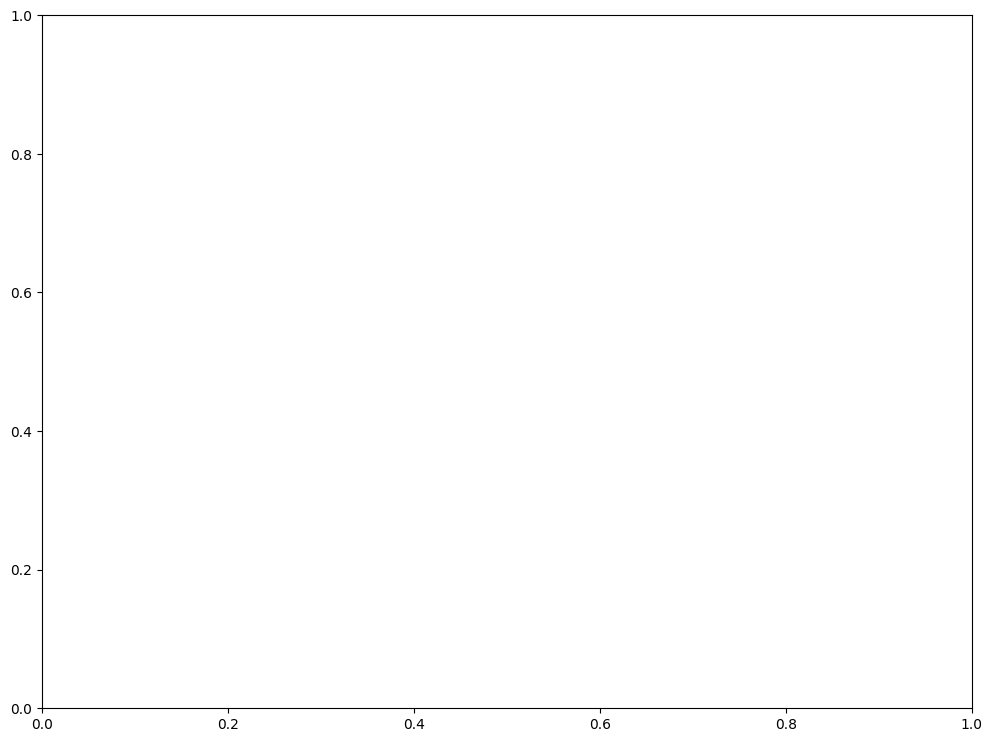

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(gama['z'], np.log10(gama['SM']), color='black', s=2)
ax.set_xlabel('z', fontsize=30, labelpad=15)
ax.set_ylabel('Masa estelar ($M_{\odot}$)', fontsize=30, labelpad=15)
ax.tick_params('both', labelsize=25)
ax.set_ylim(7, 12)
ax.add_patch(Rectangle((0,9), 0.15, 2.9, facecolor='none', ec='red', lw=4))
fig.show()

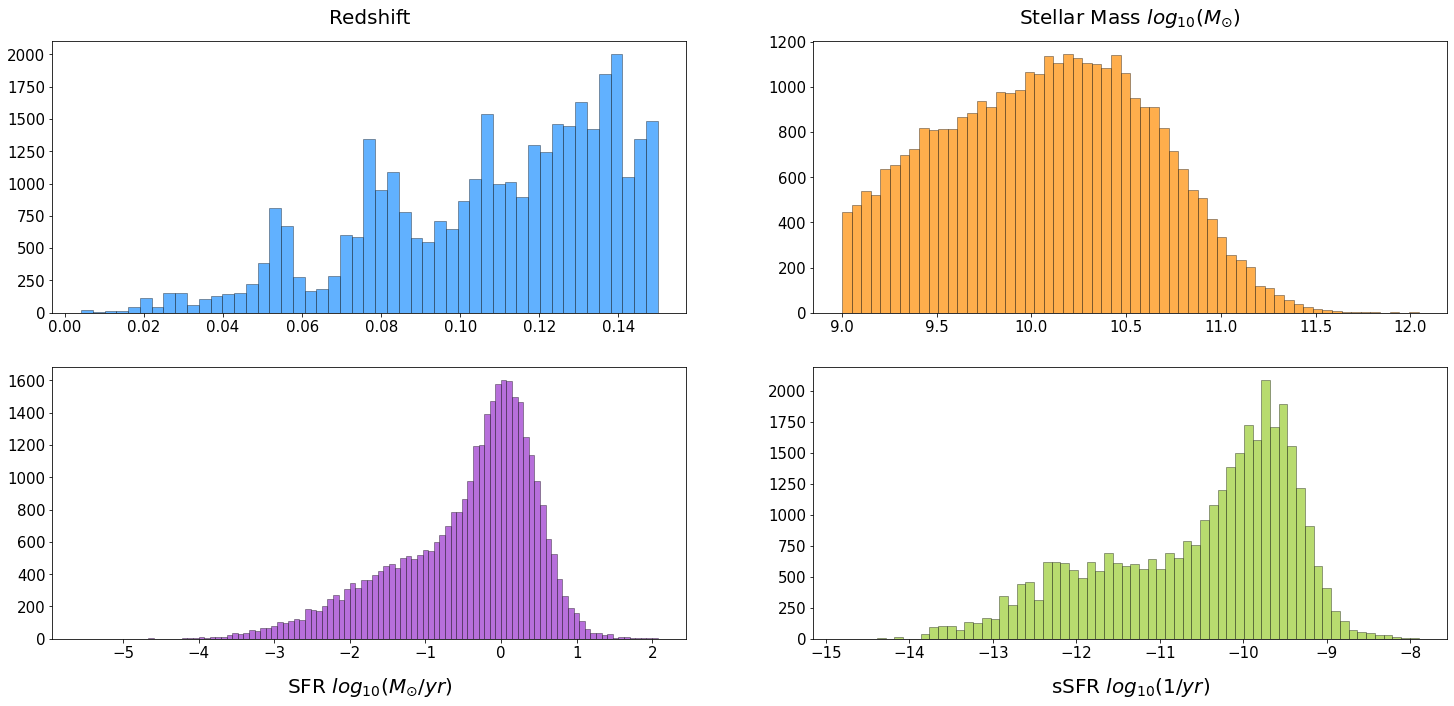

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25, 11))
ax[0,0].hist(gama_sdss['z_mp'], bins='auto', color='dodgerblue', alpha=0.7, ec='black', lw=0.5)
ax[0,1].hist(np.log10(gama_sdss['SM']), bins='auto', color='darkorange', alpha=0.7, ec='black', lw=0.5)
ax[1,0].hist(np.log10(gama_sdss['SFR']), bins='auto', color='darkorchid', alpha=0.7, ec='black', lw=0.5)
ax[1,1].hist(np.log10(gama_sdss['sSFR']), bins='auto', color='yellowgreen', alpha=0.7, ec='black', lw=0.5)
ax[0,0].set_title('Redshift', pad=17, fontsize=20)
ax[0,1].set_title(r'Stellar Mass $log_{10}(M_{\odot})$', pad=17, fontsize=20)
ax[1,0].set_xlabel(r'SFR $log_{10}(M_{\odot}/yr)$', labelpad=15, fontsize=20)
ax[1,1].set_xlabel(r'sSFR $log_{10}(1/yr)$', labelpad=15, fontsize=20)
[axis.tick_params('both', labelsize=15) for axis in ax.ravel()]
fig.show()

# GAMA and MaNGA

## MaNGA ids extractor

In [ ]:
manga_ids = []
ind = 0
for gal in gz3d['train']:
  manga_ids.append(gal['mangaid'])
  print(ind)
  ind += 1

manga_ids = [manga_ids[i].numpy().decode('utf-8') for i in range(len(manga_ids))]
manga_ids = pd.DataFrame(manga_ids)
manga_ids.to_csv('/content/drive/MyDrive/galaxy-segmentation-project/MaNGA/manga_ids.csv')

## MaNGA and GAMA comparison

In [2]:
manga_data = Table.read('/content/drive/MyDrive/galaxy-segmentation-project/MaNGA/MaNGA_targets_extNSA_tiled_ancillary.fits', format='fits')
names = [name for name in manga_data.colnames if len(manga_data[name].shape) <= 1]
manga_data = manga_data[names].to_pandas()

manga_ids_paper = pd.read_csv('/content/drive/MyDrive/galaxy-segmentation-project/MaNGA/manga_ids.csv').iloc[:,1].to_list()
manga_ids_table = [manga_data.MANGAID.to_numpy()[i].decode('utf-8') for i in range(len(manga_data))]

manga_ids_intersection = [value for value in manga_ids_paper if value in manga_ids_table]

manga_ids_intersection = [bytes(manga_ids_intersection[i], 'utf-8') for i in range(len(manga_ids_intersection))]

In [6]:
manga_ra = manga_data[manga_data['MANGAID'].isin(manga_ids_intersection)]['CATALOG_RA']
manga_dec = manga_data[manga_data['MANGAID'].isin(manga_ids_intersection)]['CATALOG_DEC']

gama_sdss_ra = gama_sdss['ra']
gama_sdss_dec = gama_sdss['DEC']

NameError: ignored

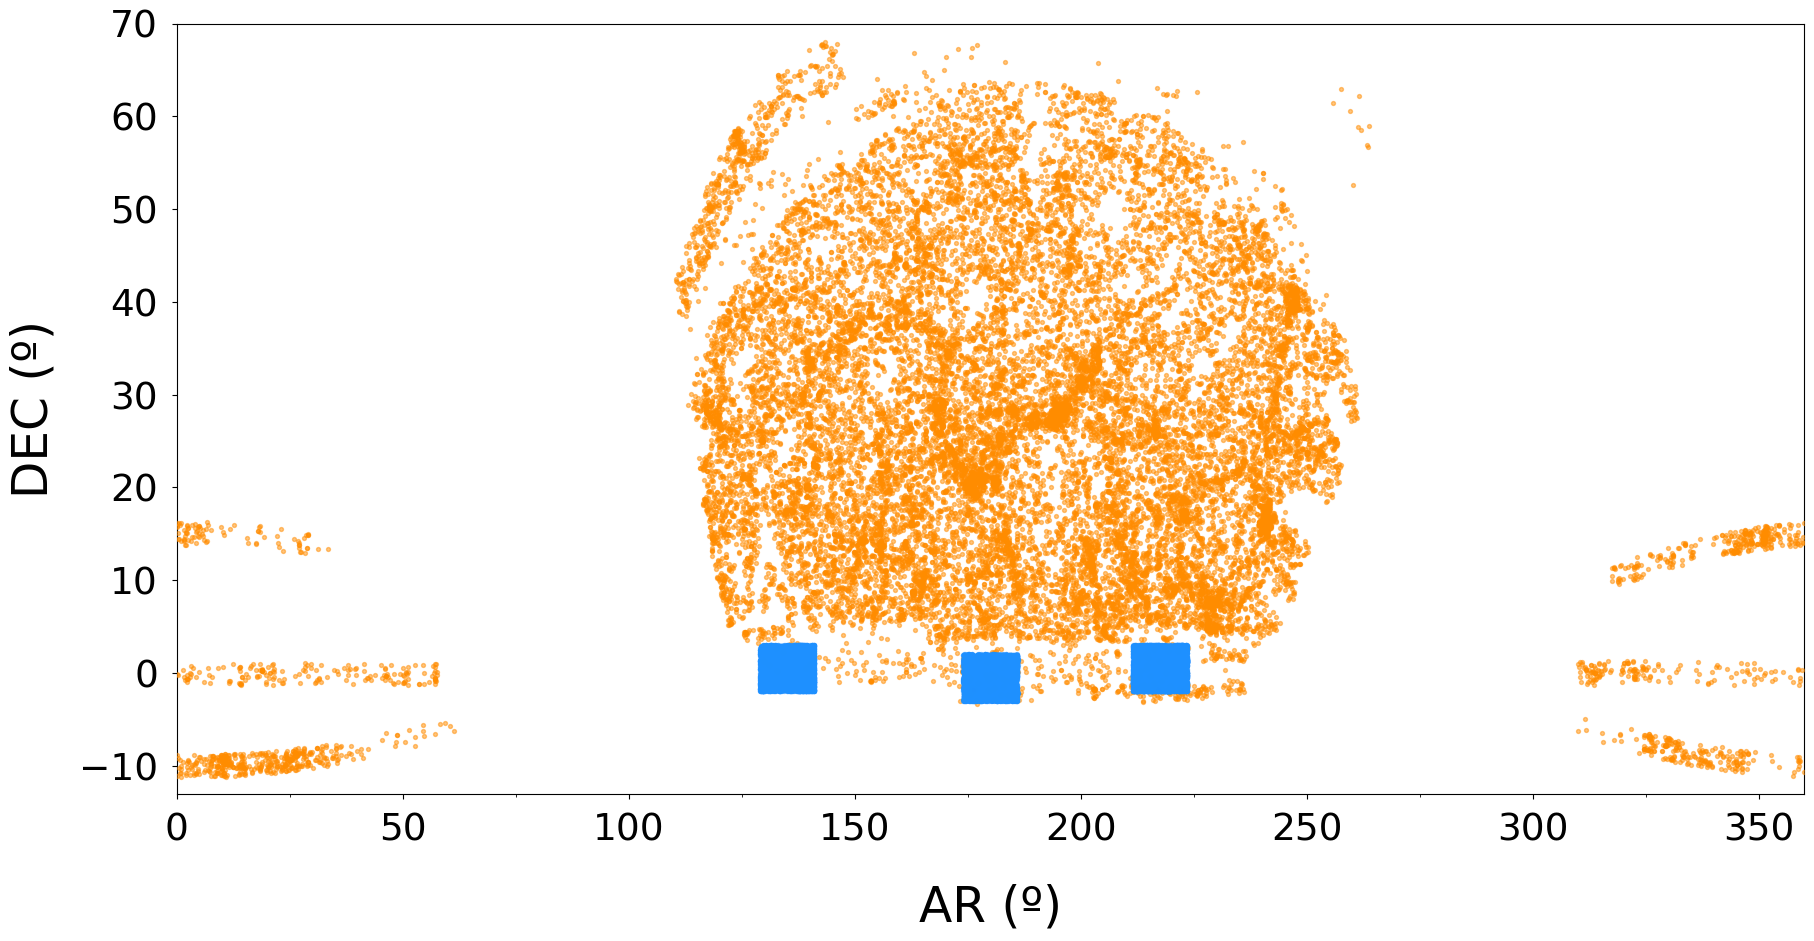

In [9]:
fig, ax = plt.subplots(figsize=(21,10))
ax.scatter(manga_ra, manga_dec, color='darkorange', alpha=0.5, label='GZ:3D', s=8, zorder=3)
ax.scatter(gama_sdss_ra, gama_sdss_dec, color='dodgerblue', alpha=0.5, label='GAMA', s=8, zorder=4)
ax.set_xlabel('AR (º)', fontsize=35, labelpad=25)
ax.set_ylabel('DEC (º)', fontsize=35, labelpad=15)
ax.tick_params('both', labelsize=27, pad=10)
ax.set_xlim(0, 360)
ax.set_ylim(-13, 70)
ax.set_xticks(np.arange(25, 375, 50), minor=True)
handles = [mpa]
ax.legend(handles=handles, labels=['GZ:3D', 'GAMA'], loc='best', fontsize=30)
ax.grid(linestyle='--', linewidth=1.6, alpha=0.5, zorder=0)
ax.xaxis.grid(which='minor', linestyle='--', linewidth=1.6, alpha=0.5, zorder=0)
leg = ax.get_legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh.set_sizes([100,100])
fig.show()

In [ ]:
np.arange(25, 375, 50)

array([ 25,  75, 125, 175, 225, 275, 325])

# GAMA mask predictions


## Useful functions

In [ ]:
def resize(input_image):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")

    return input_image


def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image


def load_image(datapoint):
    input_image = datapoint['image']
    gama_id = datapoint['cataid']
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return gama_id, input_image


def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask


def predict_unet(model, dataset_batch):
  pred_mask = create_mask(model.predict(dataset_batch))

  return pred_mask


def area_segmentation(img):
  img = rgb2gray(img)
  th_img = threshold_otsu(img)
  bw_img = img > th_img

  # Strel = morph.disk(1)
  Strel2 = morph.disk(1)

  # bw_img_dil = morph.dilation(bw_img, Strel)
  # bw_img_cls = morph.closing(bw_img_dil, Strel2)

  L = label(bw_img)
  half_length = int(np.floor(np.size(L,1)/2))
  L_cntr = L[half_length,half_length]

  Seg = L
  Seg[Seg != L_cntr] = 0
  Seg[Seg == L_cntr] = 1

  mask = morph.dilation(Seg,Strel2)

  return mask

## Data

In [ ]:
ds = tfds.load('gama', split=['train'])[0]

batches = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)

## Models

In [ ]:
model_1 = '2022_08_25-13:16:28_all_spiral-mask_epochs:150_size:128_th:1_patience:5'
model_2 = '2022_08_24-22:03:29_all_spiral-mask_epochs:150_size:128_th:2_patience:6'
model_3 = '2022_11_14-19:28:38_all_spiral-mask_epochs:150_size:128_th:3_patience:150'
model_4 = '2022_08_26-18:39:35_all_spiral-mask_epochs:150_size:128_th:4_patience:5'
model_5 = '2022_11_11-15:56:22_all_spiral-mask_epochs:50_size:128_th:5_patience:50'
model_6 = '2022_11_14-14:45:49_all_spiral-mask_epochs:50_size:128_th:6_patience:50'

models = [model_1, model_2, model_3, model_4, model_5, model_6]

In [ ]:
path = '/content/drive/MyDrive/galaxy-segmentation-project/Modelos/'

unet_models = [load_model(f'{path}{model}/{model}_best.h5') for model in models]

# Images and scores saver

## Plot function

In [ ]:
def plot_saver():
    fig, ax = plt.subplots(2, 3, figsize=(17, 11), num=1, clear=True)
    # fig, ax = plt.subplots(2, 3, figsize=(17, 11))
    ax[0,0].imshow(gal_batch[1][gal])
    ax[0,1].imshow(area_segmentation(gal_batch[1][gal]))
    ax[0,2].imshow(tf.keras.utils.array_to_img(pred_masks[1][gal]))
    ax[1,0].imshow(tf.keras.utils.array_to_img(density_mask))
    ax[1,1].imshow(tf.keras.utils.array_to_img(pred_masks[2][gal]))
    ax[1,2].imshow(tf.keras.utils.array_to_img(pred_masks[3][gal]))
    ax[0,0].set_title('Image. ID: '+str(gal_id), fontsize=23, fontweight='bold', pad=25)
    ax[0,1].set_title('Area', fontsize=23, fontweight='bold', pad=25)
    ax[0,2].set_title('th = 2', fontsize=23, fontweight='bold', pad=25)
    ax[1,0].set_xlabel('Score: '+str(round(score_3, 2)), fontsize=23, fontweight='bold', labelpad=20)
    ax[1,1].set_xlabel('th = 3', fontsize=23, fontweight='bold', labelpad=20)
    ax[1,2].set_xlabel('th = 4', fontsize=23, fontweight='bold', labelpad=20)
    [axi.set_yticklabels([]) for axi in ax.ravel()]
    [axi.set_xticklabels([]) for axi in ax.ravel()]
    [axi.tick_params(axis='both', which='both',length=0) for axi in ax.ravel()]
    fig.subplots_adjust(wspace=0.02, hspace=0.11)
    # fig.tight_layout(pad=3)
    fig.savefig(fig_path)
    # plt.close(fig)

In [ ]:
!ls /content/drive/My\ Drive/galaxy-segmentation-project/GAMA/Predicted\ Images\ \(1\) | wc -l
a = pd.read_csv('/content/drive/MyDrive/galaxy-segmentation-project/GAMA/gama_scores(1).csv')
print(len(a))

34566
34566


## Plot and scores saving

In [ ]:
path = '/content/drive/MyDrive/galaxy-segmentation-project/GAMA/'

df_scores = pd.DataFrame(columns=['GAMA ID', 'Area', 'Area th=1', 'Area th=2', 'Area th=3', 'Area th=4', 'Area th=5', 'Area th=6',
                                  'Score 1', 'Score 2', 'Score 3', 'Score 4'])

# df_scores.to_csv(f'{path}gama_scores(1).csv', header=df_scores.columns, index=False)

count = 880
t_i = time.time()


for gal_batch in batches.skip(879):

  df_scores = pd.DataFrame(columns=df_scores.columns)

  gal_ids = [gal_batch[0].numpy()[i].decode('utf8') for i in range(len(gal_batch[0]))]

  pred_masks = [predict_unet(unet_model, gal_batch[1]) for unet_model in unet_models]

  for gal in range(len(gal_batch[0])):

    gal_id = gal_ids[gal]

    area_img = area_segmentation(gal_batch[1][gal])

    density_mask = area_img.reshape(128,128,1).copy()
    for mask in range(1, len(pred_masks)):
      density_mask += pred_masks[mask][gal].numpy()

    area = np.sum(area_img)
    area_th1 = np.sum(pred_masks[0][gal])
    area_th2 = np.sum(pred_masks[1][gal])
    area_th3 = np.sum(pred_masks[2][gal])
    area_th4 = np.sum(pred_masks[3][gal])
    area_th5 = np.sum(pred_masks[4][gal])
    area_th6 = np.sum(pred_masks[5][gal])

    if area != 0:
      if np.sum(pred_masks[1][gal].numpy() & area_img.reshape(128,128,1)) == 0:
        score_1, score_2, score_3, score_4 = 0, 0, 0, 0
      else:
        score_1 = area_th3/area
        score_2 = (area_th1 + 2*area_th2 + 3*area_th3 + 4*area_th4 + 5*area_th5 + 6*area_th6)/(21*area)
        score_3 = (2*area_th2 + 3*area_th3 + 4*area_th4 + 5*area_th5 + 6*area_th6)/(20*area)
        score_4 = (3*area_th3 + 4*area_th4 + 5*area_th5 + 6*area_th6)/(18*area)
    else:
      score_1, score_2, score_3, score_4 = 0, 0, 0, 0

    results = [gal_id, area, area_th1, area_th2, area_th3, area_th4, area_th5, area_th6,
               score_1, score_2, score_3, score_4]

    df_scores.loc[len(df_scores.index)] = results

    fig_path = f'{path}Predicted Images (1)/{gal_id}.jpg'

    plot_saver()


  df_scores.to_csv(f'{path}gama_scores(1).csv', mode='a', header=False, index=False)


  t_f = time.time()
  print(f'Batch #{count}: {round((t_f-t_i)/60, 2)} mins')
  count += 1
  t_i = t_f